# Python绘图基础练习：中国地形图解
**作者：Clarmy   
个人网站：www.clarmy.net   
Email：liwentao@mail.iap.ac.cn   
GitHub：https://github.com/Clarmy**   

**提示：本notebook的内容适合具有一定Python基础的朋友练习，它主要涉及到的技能点包括：**   
- 用basemap对象绘制cyl投影底图
- 在basemap底图上叠加填色等值线图
- 对colormap进行自定义截取
- 使用边界矢量数据对等值线进行裁剪


**效果图**     
<img src='https://raw.githubusercontent.com/Clarmy/atmospheric-plot-tutorial/master/imgs/china_terrain2.png' align='left' style=' width:606px;height:373 px'/>
<img src='https://raw.githubusercontent.com/Clarmy/atmospheric-plot-tutorial/master/imgs/china_terrain.png' align='left' style=' width:606px;height:373 px'/>

## 运行环境
Python 3.6.8

**依赖包**
- numpy
- netCDF4
- matplotlib
- basemap

## 数据准备
如果想要直接运行本notebook的代码，则需要把所有数据都文件保存在该notebook存放的同级目录下。
- **地形数据**   
    使用[SRTM 90m V4.1](http://srtm.csi.cgiar.org/srtmdata/)数据集的DEM作为地形数据，本练习使用的该数据已被处理为0.05°X0.05°分辨率，并封装为nc文件，墙内网盘下载：[百度网盘](https://pan.baidu.com/s/1_6LjOxv8Cke3r8Enjj5VLg)(密码1mba)，由于百度网盘限速，如果想要获得更快的下载速度，可以使用墙外Dropbox下载：[srtm_dem.nc](https://www.dropbox.com/s/0c7cqavb02o145f/srtm_dem.nc?dl=0)   
    
    
- **边界数据**   
    边界文件为从互联网上搜集到的包含藏南等地区的无政治风险的国界数据，原始数据为shapefile文件，现已被处理为geojson格式文件，包括全国、各省、直辖市和自治区边界，可以直接使用sublime等编辑器打开查看，文件存放在GitHub的bmap代码库中（[传送门](https://github.com/Clarmy/bmaps/tree/master/boundarys/adrs/geojson)）。本文需要使用的是[NationalBoundary.geojson](https://github.com/Clarmy/bmaps/blob/master/boundarys/adrs/geojson/NationalBoundary.geojson)这个文件，你可以打开链接然后在`Raw`按钮上点右键然后点`链接存储为`进行保存。
![image.png](https://raw.githubusercontent.com/Clarmy/atmospheric-plot-tutorial/master/imgs/screenshot.png)
    （图片截取的是macOS的显示结果，Windows用户类似）

## 快速画出一张地图

In [1]:
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
from mpl_toolkits import basemap as bm

有时候Python的警告提示很烦人，我们关闭警告提示并将图片输出结果嵌入到notebook网页框架中

In [2]:
import warnings; warnings.simplefilter('ignore')
%matplotlib inline

使用netCDF4包加载srtm_dem.nc文件

In [3]:
file_obj = nc.Dataset('./srtm_dem.nc')
file_obj.variables.keys()

odict_keys(['DEM', 'lon', 'lat'])

加载经纬坐标和dem数据

In [4]:
lon = file_obj.variables['lon'][:]
lat = file_obj.variables['lat'][:]
dem = file_obj.variables['DEM'][:]

将坐标转化为网格点

In [5]:
lons,lats = np.meshgrid(lon,lat)

绘制一张全球的地形图，选择gist_earth作为colormap

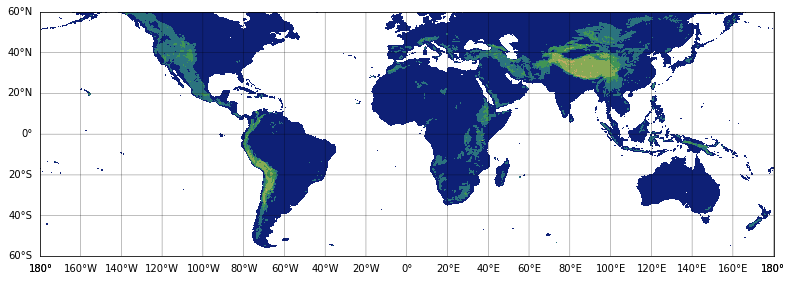

In [6]:
fig = plt.figure(figsize=(9*1.5,3*1.5))
bmap = bm.Basemap(llcrnrlon=-180,llcrnrlat=-60,urcrnrlon=180,urcrnrlat=60)
bmap.drawparallels(np.arange(-60,61,20),linewidth=0.5,labels=[1,0,0,1])
bmap.drawmeridians(np.arange(-180,181,20),linewidth=0.5,labels=[1,0,0,1])
plt.contourf(lons,lats,dem,cmap=plt.cm.gist_earth)

从图中可以看出，图片出来的效果并不好，低海拔地区被描绘为深蓝色，这是由于gist_earth这个cmap所要刻画的是包含海洋在内的地表颜色，而由于我们的dem数据在海洋地区没有值，因此这张图中就把低海拔陆地刻画为了海洋的深蓝色

想要解决这个问题，就需要对colormap进行截取

下面这个clip_cmap函数就是专门用于对colormap对象进行截取的，它可以根据你的设置在一整条colormap中截取其中一段作为最终的colormap

In [7]:
import matplotlib.colors as colors
def clip_cmap(cmap, minval=0.0, maxval=1.0, n=100):
    '''剪取colormap在某指定区间内的的色彩
    
    参数
    ---
    cmap : `matplotlib.colors.LinearSegmentedColormap`
        colormap对象
    minval : `float`
        剪取区间的左界限，数值在0-1之间，且其值须小于maxval
    maxval : `float`
        剪取区间的右界限，数值在0-1之间，且其值须大于minval
    n : `int`
        色彩间隔数，n值越大色彩数越多
    '''
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

由于海洋色处在colormap的低值区，也就是左端，因此我们将0-0.2部分切除，仅保留0.2-1部分。同样道理我们也可以切除另一个colormap：terrain，从名字我们就能看出来，它也是一个专门用来刻画地形的colormap

In [8]:
earth = clip_cmap(plt.cm.gist_earth,0.2,1)
terrain = clip_cmap(plt.cm.terrain,0.2,1)

更换了colormap以后再画出下图，我们可以看到，出来的效果比之前要好很多，至少它更接近地表的特征了。

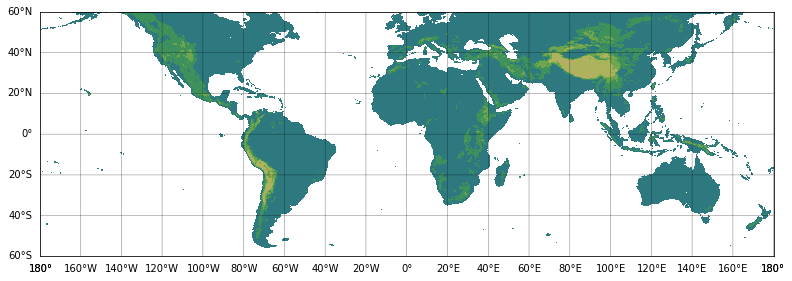

In [9]:
fig = plt.figure(figsize=(9*1.5,3*1.5))
bmap = bm.Basemap(llcrnrlon=-180,llcrnrlat=-60,urcrnrlon=180,urcrnrlat=60)
bmap.drawparallels(np.arange(-60,61,20),linewidth=0.5,labels=[1,0,0,1])
bmap.drawmeridians(np.arange(-180,181,20),linewidth=0.5,labels=[1,0,0,1])
plt.contourf(lons,lats,dem,cmap=earth)

同样的道理，使用terrain出来的效果也不错

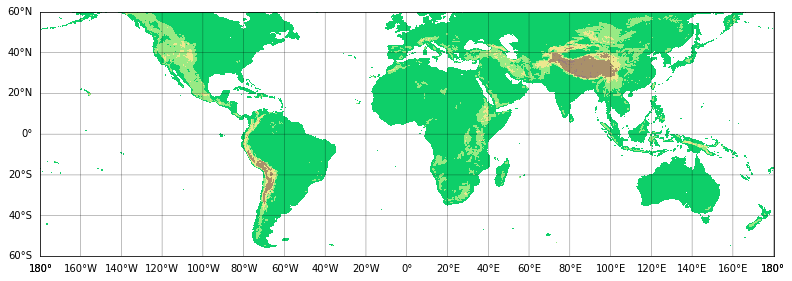

In [10]:
fig = plt.figure(figsize=(9*1.5,3*1.5))
bmap = bm.Basemap(llcrnrlon=-180,llcrnrlat=-60,urcrnrlon=180,urcrnrlat=60)
bmap.drawparallels(np.arange(-60,61,20),linewidth=0.5,labels=[1,0,0,1])
bmap.drawmeridians(np.arange(-180,181,20),linewidth=0.5,labels=[1,0,0,1])
plt.contourf(lons,lats,dem,cmap=terrain)

## 聚焦中国地区

由于全球的dem数据量较大，当我们只关注中国地区的时候，如果每次都用全球的dem数据进行处理则会耗费大量的时间成本，因此我们聚焦中国地区，剪取一片包含中国部分的区域进行计算。

In [11]:
def get_closest_index(coords,point):
    '''在坐标列表中获取距离目标点最近的点的索引
    
    参数
    ---
    coords : `list` | `ndarray`
        坐标列表，如lon列表或lat列表
    point : `float`
        目标点坐标
        
    返回
    ---
    `int` : 坐标列表上距离目标点最近点的索引值
    '''
    dists = []
    for n,value in enumerate(coords):
        diff = abs(value-point)
        dists.append((diff,n))
    index = min(dists)[1]
    return index

通过坐标拾点系统可以知道，中国陆地区域的范围大致在东经73°-139°，北纬15°-55°之间，因此可以使用上述函数寻找到dem数据坐标网格上与对应点最近的点的坐标索引，从而根据索引值截取目标区域数据。

In [12]:
left = get_closest_index(lon,73)
right = get_closest_index(lon,139)
upper = get_closest_index(lat,55)
lower = get_closest_index(lat,15)

In [13]:
print('left:%s, right:%s\nupper:%s, lower:%s'%(left,right,upper,lower))

left:5060, right:6380
upper:2300, lower:1500


通过计算可知，目标区域的左边界是第5060个点，右边界是第6380个点，上边界是第2300个点，下边界使第1500个点。通过索引值我们截取dem在该范围内的数据。截取后的结果，china_box是中国区域的dem数据矩阵,china_lon和china_lat分别是相应的坐标。

In [14]:
china_box = dem[lower:upper,left:right]
china_lon = lon[left:right]
china_lat = lat[lower:upper]

In [15]:
china_lons,china_lats = np.meshgrid(china_lon,china_lat)

根据新的区域绘制出的地形如下图所示

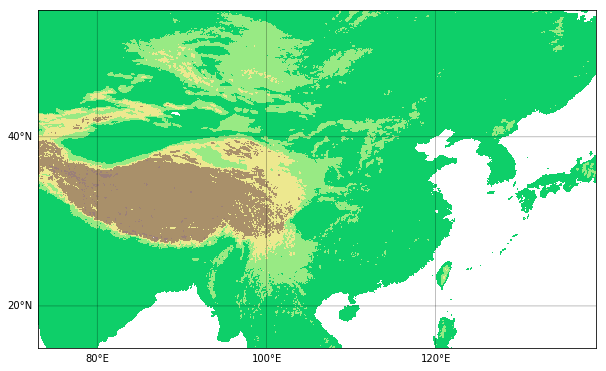

In [16]:
fig = plt.figure(figsize=(10,10))
bmap = bm.Basemap(llcrnrlon=73,llcrnrlat=15,urcrnrlon=139,urcrnrlat=55)
bmap.drawparallels(np.arange(-60,61,20),linewidth=0.5,labels=[1,0,0,1])
bmap.drawmeridians(np.arange(-180,181,20),linewidth=0.5,labels=[1,0,0,1])
plt.contourf(china_lons,china_lats,china_box,cmap=terrain)

这张图的效果看起来很粗糙，不够细腻，这是由于默认的levels层级设置太粗的原因，想要使图片看起来更细腻，可以通过调整levels参数完成，想要调整levels参数，需要先弄清楚数据矩阵中的最大值和最小值。

In [17]:
china_box.max()

8063.0

In [18]:
china_box.min()

1.0

上面两条语句告诉我们，在该目标区域中，dem的最大值是8063m，最小值是1m。这样我们可以设置在0-8000米之间以200米作为间隔来绘制该地形图。   
它的效果如下图所示

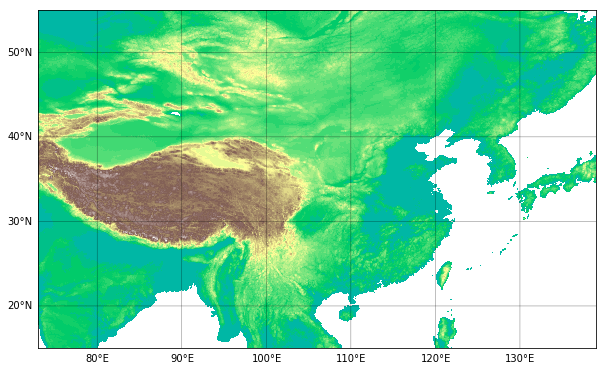

In [19]:
fig = plt.figure(figsize=(10,10))
bmap = bm.Basemap(llcrnrlon=73,llcrnrlat=15,urcrnrlon=139,urcrnrlat=55)
bmap.drawparallels(np.arange(-60,61,10),linewidth=0.5,labels=[1,0,0,1])
bmap.drawmeridians(np.arange(-180,181,10),linewidth=0.5,labels=[1,0,0,1])
plt.contourf(china_lons,china_lats,china_box,levels=np.arange(0,8000,200),cmap=terrain)

这张图看起来是不是比之前那张细腻多了。但是这张图绘制的是一个矩形范围内的地形，而不是中国行政区域内的数据。如果我们想要获取仅包括中国行政区域内的数据，就需要使用中国边界数据对地图内容进行裁剪。

# 切除中国行政区域以外的内容

要做图像切除，则需要用到matplotlib的path和patch子包，而加载geojson文件需要使用json库。

In [20]:
import json as js
from matplotlib.path import Path
from matplotlib.patches import PathPatch

In [21]:
with open('./NationalBoundary.geojson') as f:
    nb = js.load(f)

geojson是一种固定格式的地理信息json文件，本质上它就是一个json文件，只不过它的内容有一套固定的格式。   
具体内容可以参考http://geojson.org/   
对于这个文件，我们所需要的是其中的坐标信息

In [22]:
coords = nb['geometry']['coordinates']

coords存放的就是成百上千的坐标组数据，它们是一个个首尾相连的多边形。

In [23]:
len(coords)

21

它们一共存放了21个多边形，这是该文件中存放的包括中国大陆主体、台湾岛和海南岛的多边形数据。之所以它会画21个这么多，可能是因为中国东南沿海有大量小岛，该文件将部分小岛也囊括其中了，我们为了简化处理过程，就从中提取出中国大陆主体、台湾岛和海南岛三个部分，通过挑选可以知道这三个区域分别存放在其索引值的20、19和0的位置，我们直接选取它们。

In [24]:
mainland = coords[20][0]
hainan = coords[19][0]
taiwan = coords[0][0]

前面说了那么多很抽象的描述，估计有些人已经晕了，没关系，下面我们就先把处理出来的边界数据画在图上让你看清楚。

首先，我们把经度和纬度分离成两个列表，这样可以使用plt.plot函数直接出图

In [25]:
main_lons = [couple[0] for couple in mainland]
main_lats = [couple[1] for couple in mainland]

In [26]:
hainan_lons = [couple[0] for couple in hainan]
hainan_lats = [couple[1] for couple in hainan]

In [27]:
taiwan_lons = [couple[0] for couple in taiwan]
taiwan_lats = [couple[1] for couple in taiwan]

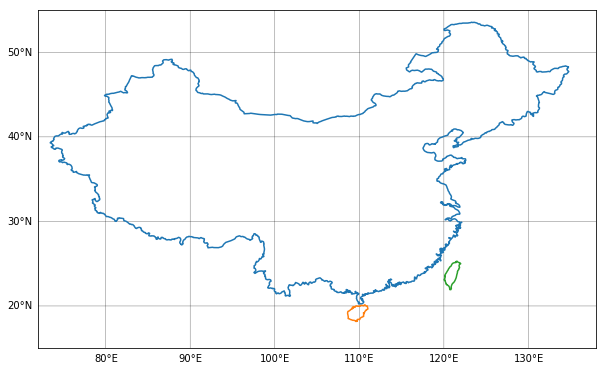

In [28]:
fig = plt.figure(figsize=(10,10))
bmap = bm.Basemap(llcrnrlon=72,llcrnrlat=15,urcrnrlon=138,urcrnrlat=55)
bmap.drawparallels(np.arange(-60,61,10),linewidth=0.5,labels=[1,0,0,1])
bmap.drawmeridians(np.arange(-180,181,10),linewidth=0.5,labels=[1,0,0,1])
plt.plot(main_lons,main_lats)
plt.plot(hainan_lons,hainan_lats)
plt.plot(taiwan_lons,taiwan_lats)

通过最简单plt.plot方法直接在图上画出了中国大陆主体、台湾岛和海南岛三个部分。后面，我们就需要使用坐标数据对图形进行切除处理。

在做切除前，我们需要了解一下Path子包中会用到的两个变量，一个在官方例子中通常写为verts，另一个通常写为codes。verts是vertex（顶点）的缩写变形，它指代的坐标点位置。codes是一种描述点与点之间关系的变量。它包含Path.MOVETO（移动），Path.LINETO（连接），Path.CLOSEPOLY（闭合）等操作。每一个verts对应一个codes，就能把线条的走向和闭合情况描述清楚，从而能够呈现出一个多边形的结果，后面的一系列处理就是根据这种数据所描述出的信息进行的。

由于我们将要对大陆主体、台湾岛和海南岛三个多边形进行剪切，为了区分三者，我们将verts和codes的名称加上地区的前缀，例如main_verts,main_codes。

In [29]:
main_verts = mainland
main_codes = [Path.LINETO] * (len(mainland)-2)
main_codes.insert(0,Path.MOVETO)
main_codes.append(Path.CLOSEPOLY)

上述代码中，由于mainland变量本来就是坐标组列表，因此可以直接将mainland变量赋值给了main_verts，作为大陆主体的顶点坐标组列表。main_codes首先建立一个比main_verts少两个元素的列表，该列表全部以Path.LINETO（连接）填充，然后在列表的开头插入Path.MOVETO（移动），在结尾插入Path.CLOSEPOLY（闭合）将元素补齐，与main_verts对应，形成闭环。

下面这一个函数相对来说比较抽象了，它的主要作用是根据你设置的路径顶点数据，把它柔和成一个Path线型对象，然后将其转化为PathPatch（路径贴片）对象，作为后续操作的一个对象参数。其实如果实在理解不了也没关系，直接把这个函数照搬下来使用就行。

In [30]:
def get_clip_patch(verts,codes):
    path = Path(verts, codes)
    clip_patch = PathPatch(path, facecolor='none',linewidth=0)
    
    return clip_patch

使用下面的程序，就可以将中国大陆主体mainland部分剪取出来了。

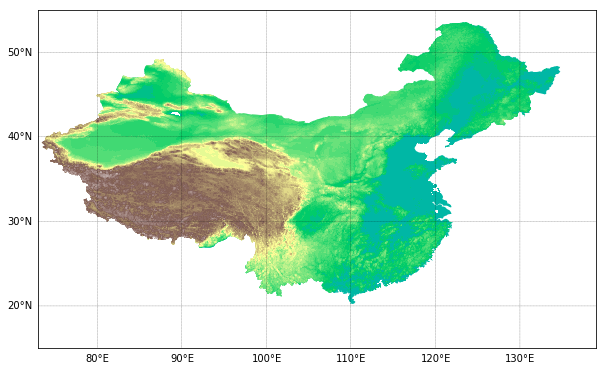

In [31]:
# 获得路径贴片参数对象
main_patch = get_clip_patch(main_verts,main_codes)

# 创建图片对象
fig = plt.figure(figsize=(10,10))

# 设置画布布局
ax = fig.add_subplot(111)

# 以main_patch作为参数加载贴片
ax.add_patch(main_patch)

# 设置底图参数
bmap = bm.Basemap(llcrnrlon=73,llcrnrlat=15,urcrnrlon=139,urcrnrlat=55)
bmap.drawparallels(np.arange(-60,61,10),linewidth=0.3,labels=[1,0,0,1])
bmap.drawmeridians(np.arange(-180,181,10),linewidth=0.3,labels=[1,0,0,1])

# 绘制等值线图
cs = plt.contourf(china_lons,china_lats,china_box,levels=np.arange(0,8000,200),cmap=terrain)
# 以main_patch作为路径贴片的参数，对等值线所有填色间隔使用set_clip_path操作
for contour in cs.collections:
    contour.set_clip_path(main_patch)

处理完了大陆主体，我们接下来我们处理台湾岛和海南岛，其过程是类似的

In [36]:
taiwan_verts = taiwan
taiwan_codes = [Path.LINETO] * (len(taiwan)-2)
taiwan_codes.insert(0,Path.MOVETO)
taiwan_codes.append(Path.CLOSEPOLY)

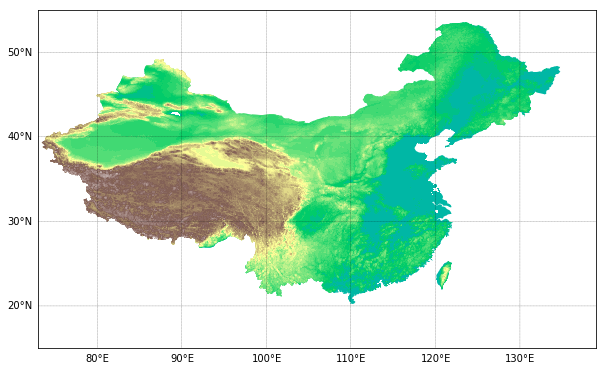

In [37]:
main_patch = get_clip_patch(main_verts,main_codes)  
taiwan_patch = get_clip_patch(taiwan_verts,taiwan_codes)  

fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(111)

ax.add_patch(main_patch)
ax.add_patch(taiwan_patch)   # 叠加新的贴片，需要在画布上声明添加

bmap = bm.Basemap(llcrnrlon=73,llcrnrlat=15,urcrnrlon=139,urcrnrlat=55)  
bmap.drawparallels(np.arange(-60,61,10),linewidth=0.3,labels=[1,0,0,1])  
bmap.drawmeridians(np.arange(-180,181,10),linewidth=0.3,labels=[1,0,0,1])  

cs = plt.contourf(china_lons,china_lats,china_box,levels=np.arange(0,8000,200),cmap=terrain)
for contour in cs.collections:
    contour.set_clip_path(main_patch)

# 增加剪取中国台湾部分，
# 这部分需要注意的是，contourf需要再画一遍，不能直接使用前面的cs，其实也很好理解，因为前面的cs已经剪完了，没有留下来更多的东西给你剪了
cs = plt.contourf(china_lons,china_lats,china_box,levels=np.arange(0,8000,200),cmap=terrain)
for contour in cs.collections:
    contour.set_clip_path(taiwan_patch)

同样的道理，海南岛也能如法炮制了。

In [38]:
hainan_verts = hainan
hainan_codes = [Path.LINETO] * (len(hainan)-2)
hainan_codes.insert(0,Path.MOVETO)
hainan_codes.append(Path.CLOSEPOLY)

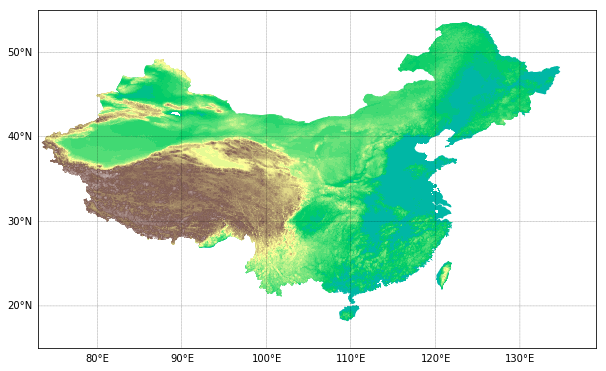

In [39]:
main_patch = get_clip_patch(main_verts,main_codes)
taiwan_patch = get_clip_patch(taiwan_verts,taiwan_codes)
hainan_patch = get_clip_patch(hainan_verts,hainan_codes)

fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(111)
ax.add_patch(main_patch)
ax.add_patch(taiwan_patch)
ax.add_patch(hainan_patch)

bmap = bm.Basemap(llcrnrlon=73,llcrnrlat=15,urcrnrlon=139,urcrnrlat=55)
bmap.drawparallels(np.arange(-60,61,10),linewidth=0.3,labels=[1,0,0,1])
bmap.drawmeridians(np.arange(-180,181,10),linewidth=0.3,labels=[1,0,0,1])

cs = plt.contourf(china_lons,china_lats,china_box,levels=np.arange(0,8000,200),cmap=terrain)
for contour in cs.collections:
    contour.set_clip_path(main_patch)

cs = plt.contourf(china_lons,china_lats,china_box,levels=np.arange(0,8000,200),cmap=terrain)
for contour in cs.collections:
    contour.set_clip_path(taiwan_patch)

cs = plt.contourf(china_lons,china_lats,china_box,levels=np.arange(0,8000,200),cmap=terrain)
for contour in cs.collections:
    contour.set_clip_path(hainan_patch)

至此，中国的地形图大体上就完成了，主要效果已经出来了。

## 调整和美化

调整和美化可以说是绘图最磨时间的事情，我们可能用10分钟画出一张图，然后用一下午去调整它。这是一个无止境的事情，在调图的过程中，我们可以使用一些小工具来提高效率，我推荐一个网站[htmlcolorcodes](https://htmlcolorcodes.com/zh/)，你可以在上面选好颜色以后它自动生成Hex码，而Hex码在Python里是可以直接作为颜色指定符的，这就极大地方便了我们调色。

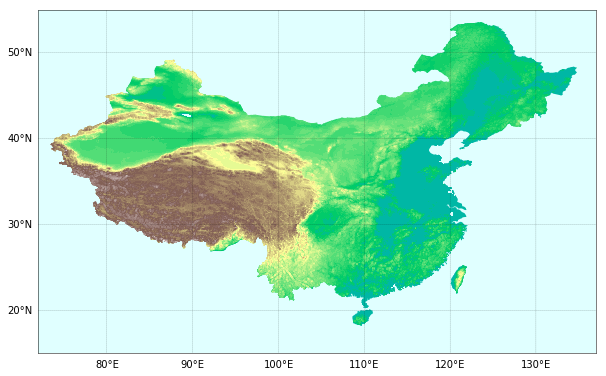

In [44]:
main_patch = get_clip_patch(main_verts,main_codes)
taiwan_patch = get_clip_patch(taiwan_verts,taiwan_codes)
hainan_patch = get_clip_patch(hainan_verts,hainan_codes)

fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(111)
ax.add_patch(main_patch)
ax.add_patch(taiwan_patch)
ax.add_patch(hainan_patch)

bmap = bm.Basemap(llcrnrlon=72,llcrnrlat=15,urcrnrlon=137,urcrnrlat=55)
bmap.drawparallels(np.arange(-60,61,10),linewidth=0.2,labels=[1,0,0,1])
bmap.drawmeridians(np.arange(-180,181,10),linewidth=0.2,labels=[1,0,0,1])
bmap.drawmapboundary(fill_color='#E0FFFF',linewidth=0.5,color='k')  # 用hex码做色彩指定，将底色设为#E0FFFF指示的颜色

cs = plt.contourf(china_lons,china_lats,china_box,levels=np.arange(0,8000,200),cmap=terrain)
for contour in cs.collections:
    contour.set_clip_path(main_patch)

cs = plt.contourf(china_lons,china_lats,china_box,levels=np.arange(0,8000,200),cmap=terrain)
for contour in cs.collections:
    contour.set_clip_path(taiwan_patch)

cs = plt.contourf(china_lons,china_lats,china_box,levels=np.arange(0,8000,200),cmap=terrain)
for contour in cs.collections:
    contour.set_clip_path(hainan_patch)
    
plt.savefig('./china_terrain.png',bbox_inches='tight')

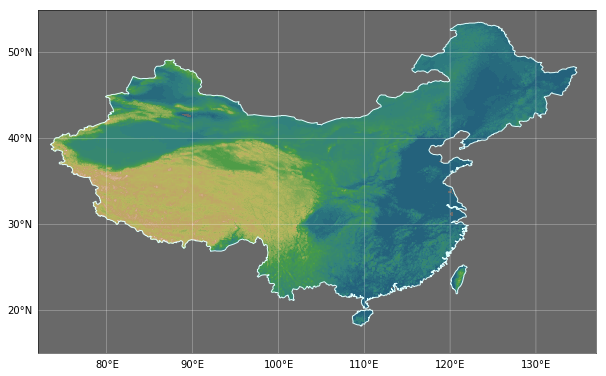

In [43]:
main_patch = get_clip_patch(main_verts,main_codes)
taiwan_patch = get_clip_patch(taiwan_verts,taiwan_codes)
hainan_patch = get_clip_patch(hainan_verts,hainan_codes)

fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(111)
ax.add_patch(main_patch)
ax.add_patch(taiwan_patch)
ax.add_patch(hainan_patch)

bmap = bm.Basemap(llcrnrlon=72,llcrnrlat=15,urcrnrlon=137,urcrnrlat=55)
bmap.drawparallels(np.arange(-60,61,10),linewidth=0.5,labels=[1,0,0,1],color='w')
bmap.drawmeridians(np.arange(-180,181,10),linewidth=0.5,labels=[1,0,0,1],color='w')
bmap.drawmapboundary(fill_color='#696969',linewidth=0.5,color='k')

cs = plt.contourf(china_lons,china_lats,china_box,levels=np.arange(0,8000,200),cmap=earth)
for contour in cs.collections:
    contour.set_clip_path(main_patch)

cs = plt.contourf(china_lons,china_lats,china_box,levels=np.arange(0,8000,200),cmap=earth)
for contour in cs.collections:
    contour.set_clip_path(taiwan_patch)

cs = plt.contourf(china_lons,china_lats,china_box,levels=np.arange(0,8000,200),cmap=earth)
for contour in cs.collections:
    contour.set_clip_path(hainan_patch)
    
plt.plot(main_lons,main_lats,linewidth=1,color='#E0FFFF')
plt.plot(taiwan_lons,taiwan_lats,linewidth=1,color='#E0FFFF')
plt.plot(hainan_lons,hainan_lats,linewidth=1,color='#E0FFFF')

plt.savefig('./china_terrain2.png',bbox_inches='tight')

## 举一反三
这个练习是使用中国的国界线矢量数据对dem数据进行裁剪处理，当然你也可以使用其他的数字矩阵和其他省市的边界文件进行裁剪处理。

## 参考/延伸阅读
https://basemaptutorial.readthedocs.io/en/latest/clip.html   
https://matplotlib.org/gallery/shapes_and_collections/path_patch.html   
https://basemaptutorial.readthedocs.io/en/latest/  
https://cgiarcsi.community/data/srtm-90m-digital-elevation-database-v4-1/   
http://geojson.org/